# Vamos a reproducir el escenario de Vegetti, et al. 2012

In [ ]:
# # 1) Importar el cosmology de Astropy
# from astropy.cosmology import FlatLambdaCDM

# # 2) Crear la instancia de cosmología plana ΛCDM
# #    - H0: 70 km/s/Mpc, Om0: 0.3, Ob0: 0.048 (puedes ajustar según prefieras)
# cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.048)

# # 3) Definir los redshifts extraídos del paper
# z_lens   = 0.881   # redshift de la galaxia lente principal
# z_source = 2.059   # redshift de la fuente de fondo

# # 4) Crear el objeto LensCosmo de Lenstronomy
# from lenstronomy.Cosmo.lens_cosmo import LensCosmo
# lens_cosmo = LensCosmo(z_lens=z_lens, z_source=z_source, cosmo=cosmo)


In [ ]:
# Rs_angle, alpha_Rs = lens_cosmo.nfw_physical2angle(M=1e13, c=6)


In [ ]:
import numpy as np
from astropy import units as u
from astropy.constants import G, c
from astropy.cosmology import FlatLambdaCDM
from lenstronomy.Cosmo.lens_cosmo import LensCosmo

# datos
z_lens, z_source = 0.881, 2.059
M_sub = 2.1e8 * u.M_sun

# cosmología y distancias
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.048)
lens_cosmo = LensCosmo(z_lens, z_source, cosmo)
D_d  = cosmo.angular_diameter_distance(z_lens)
D_s  = cosmo.angular_diameter_distance(z_source)
D_ds = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)

# … (todo igual hasta thetaE_rad)
thetaE_rad = np.sqrt(4 * G * M_sub / c**2 * D_ds/(D_d * D_s))

# Indicar que thetaE_rad es un ángulo en radianes
thetaE = thetaE_rad * u.rad

# Ahora convertir radianes → arcsec
thetaE_sub = thetaE.to(u.arcsec).value
print(f"θ_E subhalo SIS ≃ {thetaE_sub:.4f}\"")

θ_E subhalo SIS ≃ 0.0214"


Primero vamos a trabajar con el modelo y perfil de la lente:

In [36]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Util.param_util import phi_q2_ellipticity, shear_polar2cartesian

#Dado que la lente y el satélite están al mismo redshift, podemos utilizar un single plane
# --- 3) Parámetros de la lente principal (EPL) ---
theta_E_main = 0.452
gamma_main   = 2.042
phi_main     = np.deg2rad(-22.29)
q_main       = 0.866
e1, e2       = phi_q2_ellipticity(phi=phi_main, q=q_main)

kwargs_main = {
    'theta_E':  theta_E_main,
    'gamma':    gamma_main,
    'e1':       e1,
    'e2':       e2,
    'center_x': 0.0,
    'center_y': 0.0
}

# --- 4) Parámetros de shear externo ---
Gamma     = 0.015
GammaPhi  = np.deg2rad(107.9)
g1, g2    = shear_polar2cartesian(phi=GammaPhi, gamma=Gamma)
kwargs_shear = {'gamma1': g1, 'gamma2': g2}

# --- 5) Parámetros del subhalo SIS ---
x_sub, y_sub = 0.034, 0.571
kwargs_sis = {
    'theta_E':  thetaE_sub,
    'center_x': x_sub,
    'center_y': y_sub
}

# --- 6) Instanciar LensModel con EPL + SIS + shear ---
lens_model_list = ['EPL', 'SIS', 'SHEAR_REDUCED']
lensModel = LensModel(lens_model_list=lens_model_list)
kwargs_lens = [kwargs_main, kwargs_sis, kwargs_shear]


# #Modelamos la lente con un EPL y el satélite con un perfil de SIS
# lens_model_list = ['EPL', 'SIS' ,'SHEAR']
# lensModel = LensModel(lens_model_list=lens_model_list)



Ahora vamos a trabajar el perfil de la fuente que es un perfil extendido con un quasar.

Primero creamos el mapa de pixeles del plano fuente

In [37]:
# Tamaño de píxel en arcsec (HST/WFC3‐IR o Keck AO usan ~0.05")
deltaPix = 0.05  

# Número de píxeles por lado: 80 × 0.05" = 4" 
nx, ny = 80, 80  

ra_at_xy_0  = - (nx * deltaPix) / 2  # = -2.0  
dec_at_xy_0 = - (ny * deltaPix) / 2  # = -2.0  

import numpy as np
transform_pix2angle = np.array([[-deltaPix, 0],
                                [       0, deltaPix]])

from lenstronomy.Data.pixel_grid import PixelGrid

kwargs_pixel = {
    'nx': nx,
    'ny': ny,
    'ra_at_xy_0':  ra_at_xy_0,
    'dec_at_xy_0': dec_at_xy_0,
    'transform_pix2angle': transform_pix2angle
}
pixel_grid = PixelGrid(**kwargs_pixel)

#las cooedenadas donde se ubican los píxeles
x_grid, y_grid = pixel_grid.pixel_coordinates

In [44]:
# 4) Elegir un punto en el plano imagen (observador)
theta_ra, theta_dec = 1.3, 0.0

# 5) Ray‐shooting: calcular su origen en el plano fuente
#    β = θ − α(θ)
beta_ra, beta_dec = lensModel.ray_shooting(
    theta_ra, theta_dec, kwargs_lens)

In [49]:
#Aquí vamos a definir el modelo y parámetros de luz de la parte extendida de la galaxia, que es un perfil de sersic circular

from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource

#Esto es la parte de la galaxia que tiene un perfil de sersic circular
source_light_model_list = ['SERSIC']
lightModel_source = LightModel(light_model_list=source_light_model_list)

kwargs_light_source = [{
    'amp':       1.0,    # normalización arbitraria de brillo (counts/s/arcsec²)
    'R_sersic':  0.15,   # radio efectivo ~0.15″ ≃ 1.2 kpc a z≈2
    'n_sersic':  1.0,    # índice de Sérsic exponencial (disco‐like)
    'center_x':  ra_at_xy_0,    # fuente centrada en el origen del plano fuente
    'center_y':  dec_at_xy_0,    # fuente centrada en el origen del plano fuente
}]


# ————————————————————————————————————————————————
# A) Compute the lensed image positions & amplitudes
#    given a source at (beta_ra, beta_dec) with intrinsic flux source_amp

# 2) Specify the “unlensed” source model: we know its RA/DEC in the source plane
point_source_model_list = ['SOURCE_POSITION']

# 3) Instantiate PointSource, telling it:
#    - which LensModel to use (lensModel)
#    - that the magnification is fixed (we supply source_amp directly)
pointSource = PointSource(
    point_source_type_list=point_source_model_list,
    lens_model=lensModel,
    fixed_magnification_list=[True]
)

# 9) Define the image parameters:
#    ra_image, dec_image = known image-plane positions (theta_i)
#    point_amp           = measured counts at those pixels
#                         (here we scale by magnification as an example)
kwargs_ps = [{
    'ra_image':  theta_ra,
    'dec_image': theta_dec,
    'point_amp': abs(mag) * 30
}]

# ————————————————————————————————————————————————
# B) Invert: compute the implied source from given image positions & observed flux

# 7) Specify the “lensed” model: we know image-plane RA/DEC of a point
point_source_model_list = ['LENSED_POSITION']

# 8) Instantiate PointSource in inverse mode:
#    - fixed_magnification=False allows the solver to compute source_amp 
#      from observed image flux * magnification
pointSource = PointSource(
    point_source_type_list=point_source_model_list,
    lens_model=lensModel,
    fixed_magnification_list=[False]
)

# 9) Define the image parameters:
#    ra_image, dec_image = known image-plane positions (theta_i)
#    point_amp           = measured counts at those pixels
#                         (here we scale by magnification as an example)
kwargs_ps = [{
    'ra_image':  theta_ra,
    'dec_image': theta_dec,
    'point_amp': abs(mag) * 30
}]

# 10) Given those image positions & fluxes, recover:
#    - source-plane coordinates
#    - intrinsic source flux
x_pos, y_pos = pointSource.image_position(
    kwargs_ps=kwargs_ps,
    kwargs_lens=kwargs_lens
)
point_amp = pointSource.image_amplitude(
    kwargs_ps=kwargs_ps,
    kwargs_lens=kwargs_lens
)

Ahora hacemos el mapeo al plano del observador:

In [50]:
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

# 1) Instanciar el solver asociado a tu LensModel
solver = LensEquationSolver(lensModel)

# 2) Dada la posición de la fuente (beta_ra, beta_dec),
#    busca numéricamente todas las soluciones de θ.
theta_ra, theta_dec = solver.image_position_from_source(
    ra_at_xy_0, dec_at_xy_0, kwargs_lens
)

# 3) Ya tienes un array con todas las imágenes puntuales θ_i.
#    Puedes consultar su magnificación:
mag = lensModel.magnification(theta_ra, theta_dec, kwargs_lens)


In [51]:
# 3) Configurar la simulación de la imagen
from lenstronomy.ImSim.image_model import ImageModel

# Importamos la clase que gestiona el Point Spread Function (PSF)
from lenstronomy.Data.psf import PSF

# Definimos un diccionario con los parámetros del PSF:
#  - psf_type: 'GAUSSIAN' para un PSF analítico gaussiano.
#  - fwhm: Full Width at Half Maximum en arcsec, controla el ancho de la gaussiana.
#  - pixel_size: tamaño angular de cada píxel, necesario para convertir fwhm→núcleo en píxeles.
kwargs_psf = {
    'psf_type':   'GAUSSIAN',
    'fwhm':       0.1,
    'pixel_size': deltaPix
}

# Creamos la instancia del PSF con esos parámetros
psf = PSF(**kwargs_psf)

# Obtenemos el kernel de convolución para un punto fuente:
#  es un array 2D centrado que representa el perfil de respuesta a un δ–función.
kernel = psf.kernel_point_source
psf = PSF(**kwargs_psf)


# Ajustes numéricos para controlar submuestreo y dónde se aplica la convolución
kwargs_numerics = {
    'supersampling_factor':      1,    # no subdividir cada píxel en sub-píxeles
    'supersampling_convolution': False # aplicar el PSF después de muestrear de vuelta al grid original
}

# Creamos la “fábrica de imágenes” combinando todos los ingredientes:
imageModel = ImageModel(
    data_class            = pixel_grid,         # rejilla de píxeles ↔ ángulos
    psf_class             = psf,                # kernel de difracción / seeing
    lens_model_class      = lensModel,          # perfiles de masa (EPL, SHEAR, subhalo…)
    source_model_class    = lightModel_source,  # perfil(es) de luz de la fuente
    # lens_light_model_class= lightModel_lens,    # perfil(es) de luz de la lente
    point_source_class    = None,               # aquí no simulamos quásares puntuales
    kwargs_numerics       = kwargs_numerics     # parámetros de precisión numérica
)

# 4) Simular la imagen “perfecta” sin ruido
#    Se combinan:
#      • Ray–shooting inverso de cada píxel/sub-píxel
#      • Evaluación de brillo de la fuente y de la lente
#      • Convolución con el PSF (aquí, tras muestrear de vuelta)
#    Resultado: un array 2D con “counts” por píxel
image = imageModel.image(
    kwargs_lens       = kwargs_lens,        # parámetros de masa (EPL, SHEAR, subhalo…)
    kwargs_source     = kwargs_light_source,# parámetros del perfil de la fuente (Sérsic, etc.)
    # kwargs_lens_light = kwargs_light_lens,  # parámetros del perfil de la luz de la lente
    kwargs_ps         = kwargs_ps           # parámetros de fuentes puntuales (None aquí)
)


/tmp/ipykernel_3961/2874896410.py:46: RuntimeWarning: invalid value encountered in log10
  axes[1].matshow(np.log10(image_noisy),  origin='lower')


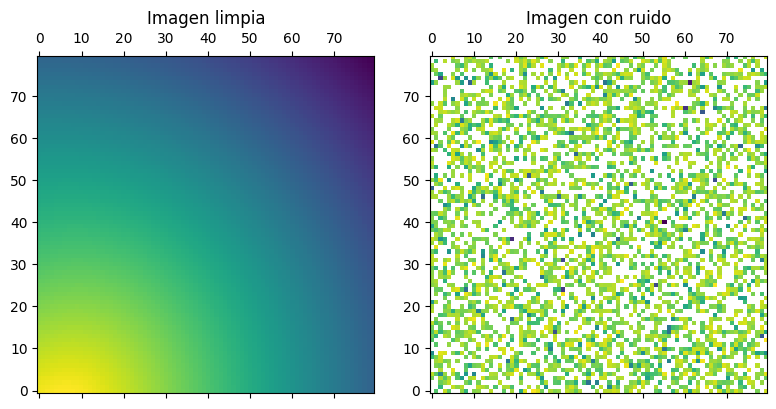

In [53]:
# 1) Importar la clase ImageModel
from lenstronomy.ImSim.image_model import ImageModel

# 2) Definir parámetros numéricos de precisión
kwargs_numerics = {
    'supersampling_factor':       1,    # No subdivide cada pixel
    'supersampling_convolution': False # Convolucionar tras re-muestrear
}

# 3) Instanciar ImageModel uniendo todos los componentes previos:
imageModel = ImageModel(
    data_class=pixel_grid,              # rejilla y WCS
    psf_class=psf,                      # difracción/seeing
    lens_model_class=lensModel,         # perfil(es) de masa
    source_model_class=lightModel_source,  # luz de la fuente
    #lens_light_model_class=lightModel_lens, # luz de la lente
    point_source_class=None,            # no hay quásares puntuales aquí
    kwargs_numerics=kwargs_numerics
)

# 4) Simular la imagen limpia (counts por pixel)
image = imageModel.image(
    kwargs_lens=kwargs_lens,            # parámetros de masa
    kwargs_source=kwargs_light_source,  # parámetros de la fuente
    #kwargs_lens_light=kwargs_light_lens,# parámetros de la luz de la lente
    kwargs_ps=kwargs_ps                 # parámetros de puntos, aquí None
)

# 5) Añadir ruido realista
import lenstronomy.Util.image_util as image_util

exp_time       = 100    # segundos: escala del ruido Poisson
background_rms = 0.1    # counts rms del fondo

poisson    = image_util.add_poisson(image, exp_time=exp_time)
bkg        = image_util.add_background(image, sigma_bkd=background_rms)
image_noisy = image + poisson + bkg

# 6) Visualizar lado a lado (limpia vs. ruidosa)
import matplotlib.pyplot as plt
import numpy as np

f, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].matshow(np.log10(image),        origin='lower')
axes[0].set_title("Imagen limpia")
axes[1].matshow(np.log10(image_noisy),  origin='lower')
axes[1].set_title("Imagen con ruido")
#for ax in axes: ax.set_axis_off()
f.tight_layout()
plt.show()


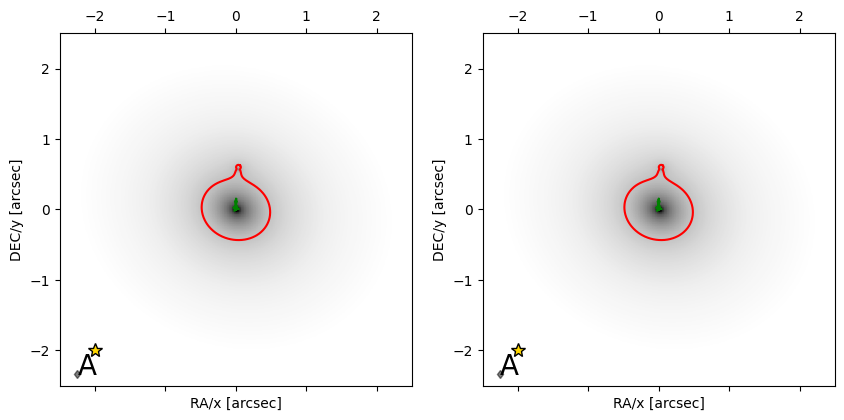

In [26]:
from lenstronomy.Plots import lens_plot
import matplotlib.pyplot as plt

f, axes = plt.subplots(1, 2, figsize=(10, 5))

# 1) Modelo single‐plane
lens_plot.lens_model_plot(
    axes[0],
    lensModel=lensModel,
    kwargs_lens=kwargs_lens,
    sourcePos_x=ra_at_xy_0,
    sourcePos_y=dec_at_xy_0,
    point_source=True,
    with_caustics=True,
    fast_caustic=True,
    coord_inverse=False
)

# 2) Modelo multi‐plane
lens_plot.lens_model_plot(
    axes[1],
    lensModel=lensModel,
    kwargs_lens=kwargs_lens,
    sourcePos_x=ra_at_xy_0,
    sourcePos_y=dec_at_xy_0,
    point_source=True,
    with_caustics=True,
    fast_caustic=True,
    coord_inverse=False
)

plt.show()


In [ ]:
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

# 1) Instanciar el solver asociado a tu LensModel
solver = LensEquationSolver(lensModel)

# 2) Dada la posición de la fuente (beta_ra, beta_dec),
#    busca numéricamente todas las soluciones de θ.
theta_ra, theta_dec = solver.image_position_from_source(
    beta_ra, beta_dec, kwargs_lens
)

# 3) Ya tienes un array con todas las imágenes puntuales θ_i.
#    Puedes consultar su magnificación:
mag = lensModel.magnification(theta_ra, theta_dec, kwargs_lens)


Aquí vamos a definir la rejilla para el plano fuente

Vamos a visualizar el perfil original según lo detallado en el paper:

Como lo que tenemos es una galaxia que tiene un quasar, entonces vamos a hacer que ambos perfiles coexistan siendo estos un perfil de sersic circular para la parte estelar y del medio y una fuente puntual para el quasar

Esto se combina en la clase $\texttt{ImageModel}$, primero vamos a definir el perfil y parámetros del sersic y luego el de la fuente puntual.

NameError: name 'lensModel' is not defined

In [ ]:



# 3) Instantiate PointSource, telling it:
#    - which LensModel to use (lensModel)
#    - that the magnification is fixed (we supply source_amp directly)
pointSource = PointSource(
    point_source_type_list=point_source_model_list,
    lens_model=lensModel,
    fixed_magnification_list=[True]
)

# 4) Define the source parameters:
#    ra_source, dec_source = source plane coordinates
#    source_amp            = intrinsic brightness
kwargs_ps = [{
    'ra_source':  beta_ra,
    'dec_source': beta_dec,
    'source_amp': 100
}]

# 5) Compute the multiple lensed image positions (theta_i) of that source
x_pos, y_pos = pointSource.image_position(
    kwargs_ps=kwargs_ps,
    kwargs_lens=kwargs_lens
)

# 6) Compute the observed amplitudes at those image positions.
#    Since magnification is fixed, this returns exactly source_amp.
point_amp = pointSource.image_amplitude(
    kwargs_ps=kwargs_ps,
    kwargs_lens=kwargs_lens
)

# ————————————————————————————————————————————————
# B) Invert: compute the implied source from given image positions & observed flux

# 7) Specify the “lensed” model: we know image-plane RA/DEC of a point
point_source_model_list = ['LENSED_POSITION']

# 8) Instantiate PointSource in inverse mode:
#    - fixed_magnification=False allows the solver to compute source_amp 
#      from observed image flux * magnification
pointSource = PointSource(
    point_source_type_list=point_source_model_list,
    lens_model=lensModel,
    fixed_magnification_list=[False]
)

# 9) Define the image parameters:
#    ra_image, dec_image = known image-plane positions (theta_i)
#    point_amp           = measured counts at those pixels
#                         (here we scale by magnification as an example)
kwargs_ps = [{
    'ra_image':  theta_ra,
    'dec_image': theta_dec,
    'point_amp': abs(mag) * 30
}]

# 10) Given those image positions & fluxes, recover:
#    - source-plane coordinates
#    - intrinsic source flux
x_pos, y_pos = pointSource.image_position(
    kwargs_ps=kwargs_ps,
    kwargs_lens=kwargs_lens
)
point_amp = pointSource.image_amplitude(
    kwargs_ps=kwargs_ps,
    kwargs_lens=kwargs_lens
)

In [5]:
# 3) Configurar el PSF
from lenstronomy.Data.psf import PSF

# Elegimos un PSF Gaussiano con FWHM = 0.1"
# y la misma escala de píxel definida en el punto 2 (deltaPix).
kwargs_psf = {
    'psf_type':   'GAUSSIAN',  # 'GAUSSIAN' ó 'PIXEL'
    'fwhm':       0.1,         # FWHM en arcsec
    'pixel_size': deltaPix     # escala de píxel (arcsec/píxel)
}
psf = PSF(**kwargs_psf)        # instancia del PSF :contentReference[oaicite:5]{index=5}

# Para usarse en ImageModel:
# - Convolution kernel para emisores extendidos:
kernel_extended = psf.kernel_pixel

# - Kernel puntual (para point sources):
kernel_point_source = psf.kernel_point_source


In [7]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Util import param_util
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from astropy.cosmology import FlatLambdaCDM

# Cosmología y subhalo NFW como antes
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.05)
lens_cosmo = LensCosmo(z_lens=0.881, z_source=2.059, cosmo=cosmo)
Rs_angle, alpha_Rs = lens_cosmo.nfw_physical2angle(M=1.7e8, c=15)

# 1) Usamos SIE en lugar de SPEMD
lens_model_list = ['SIE', 'NFW', 'SHEAR_REDUCED']
lensModel = LensModel(lens_model_list=lens_model_list)

# 2) Parámetros de la SIE (en arcsec y elípticidad e1,e2)
#    Aquí approximamos θ_E y e1,e2 que antes venían de SPEMD
e1, e2 = param_util.phi_q2_ellipticity(phi=0.5, q=0.7)
kwargs_sie = {
    'theta_E': 0.57,
    'e1':       e1,
    'e2':       e2,
    'center_x': 0.0,
    'center_y': 0.0
}

# 3) Parámetros del subhalo NFW (igual que antes)
kwargs_nfw = {
    'Rs':       Rs_angle,
    'alpha_Rs': alpha_Rs,
    'center_x': 0.60,
    'center_y': -0.40
}

# 4) Parámetros de shear reducido
gamma_ext, psi_ext = 0.03, 0.2
gamma1, gamma2 = param_util.shear_polar2cartesian(phi=psi_ext, gamma=gamma_ext)
kwargs_shear = {'gamma1': gamma1, 'gamma2': gamma2}

# 5) Lista completa de kwargs en el mismo orden que lens_model_list
kwargs_lens = [kwargs_sie, kwargs_nfw, kwargs_shear]


In [12]:
# 5) Importar la clase LightModel
from lenstronomy.LightModel.light_model import LightModel
import lenstronomy.Util.param_util as param_util

# 5.3) Configurar el perfil de luz de la FUENTE (Sérsic circular)
source_light_model_list = ['SERSIC']
lightModel_source = LightModel(light_model_list=source_light_model_list)

# Parámetros del perfil de la fuente:
#  - amp:  normalización del brillo (counts/s/arcsec²)
#  - R_sersic: radio efectivo (arcsec)
#  - n_sersic: índice de Sérsic
#  - center_x, center_y: posición en el plano fuente (estamos centrando en (0,0))
kwargs_light_source = [{
    'amp':       1.0,
    'R_sersic':  0.2,
    'n_sersic':  1.0,
    'center_x':  0.0,
    'center_y':  0.0
}]

# 5.4) Configurar el perfil de luz de la LENTE (Sérsic elíptico)
lens_light_model_list = ['SERSIC_ELLIPSE']
lightModel_lens = LightModel(light_model_list=lens_light_model_list)

# Convertir (phi,q) → (e1,e2) para definir la elipticidad
phi_lens, q_lens = 0.5, 0.9
e1_lens, e2_lens = param_util.phi_q2_ellipticity(phi=phi_lens, q=q_lens)

# Parámetros del perfil de la lente:
#  - amp:      brillo de la galaxia lente (counts/s/arcsec²)
#  - R_sersic: radio efectivo (arcsec)
#  - n_sersic: índice de Sérsic (más concentrado que la fuente)
#  - e1, e2:   elipticidad
#  - center_x, center_y: asumimos céntrico con pequeño offset opcional
kwargs_light_lens = [{
    'amp':       100.0,
    'R_sersic':  0.8,
    'n_sersic':  3.5,
    'e1':        e1_lens,
    'e2':        e2_lens,
    'center_x':  0.0,
    'center_y':  0.0
}]


In [13]:
kwargs_numerics = {
    'supersampling_factor':      1,    # no subdividir cada píxel
    'supersampling_convolution': False # convolucionar tras re-muestrear
}


In [14]:
from lenstronomy.ImSim.image_model import ImageModel

imageModel = ImageModel(
    data_class             = pixel_grid,        # Punto 2
    psf_class              = psf,               # Punto 3
    lens_model_class       = lensModel,         # Punto 4
    source_model_class     = lightModel_source, # Punto 5
    lens_light_model_class = lightModel_lens,   # Punto 5
    point_source_class     = None,              # sin fuentes puntuales
    kwargs_numerics        = kwargs_numerics
)


In [15]:
image_full = imageModel.image(
    kwargs_lens       = kwargs_lens,        # [principal, subhalo, shear]
    kwargs_source     = kwargs_light_source,# perfil Sérsic de la fuente
    kwargs_lens_light = kwargs_light_lens,  # perfil Sérsic de la lente
    kwargs_ps         = None                # no hay point sources
)


In [16]:
import lenstronomy.Util.image_util as image_util

exp_time       = 100    # segundos de exposición
background_rms = 0.1    # counts RMS de ruido de fondo

# Ruido Poissoniano
poisson = image_util.add_poisson(image_full, exp_time=exp_time)
# Ruido de fondo Gaussiano
bkg     = image_util.add_background(image_full, sigma_bkd=background_rms)
# Imagen final con ruido
image_noisy = image_full + poisson + bkg


NameError: name 'beta_ra' is not defined

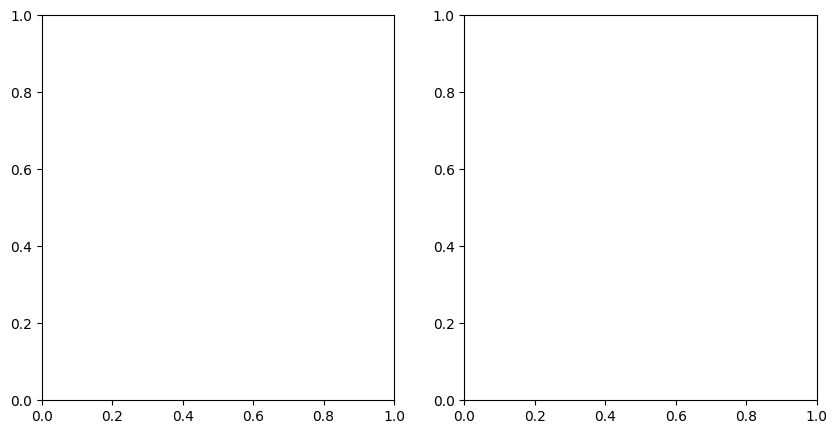

In [19]:
from lenstronomy.Plots import lens_plot
import matplotlib.pyplot as plt

f, axes = plt.subplots(1, 2, figsize=(10, 5))

# 1) Modelo single‐plane
lens_plot.lens_model_plot(
    axes[0],
    lensModel=lensModel,
    kwargs_lens=kwargs_lens,
    sourcePos_x=beta_ra,
    sourcePos_y=beta_dec,
    point_source=True,
    with_caustics=True,
    fast_caustic=True,
    coord_inverse=False
)


/tmp/ipykernel_7973/3495728422.py:7: RuntimeWarning: invalid value encountered in log10
  axes[1].imshow(np.log10(image_noisy), origin='lower')


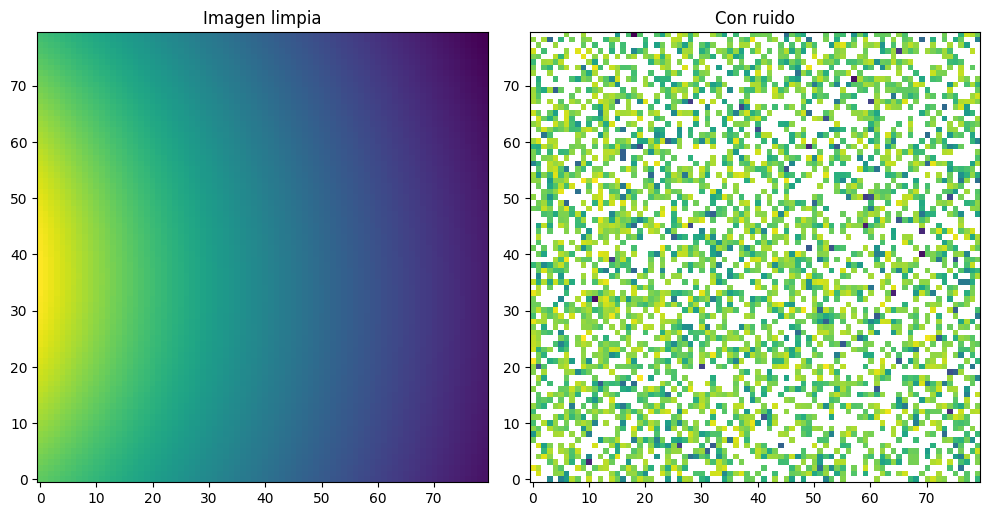

In [18]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(np.log10(image_full),  origin='lower')
axes[0].set_title('Imagen limpia')
axes[1].imshow(np.log10(image_noisy), origin='lower')
axes[1].set_title('Con ruido')
#for ax in axes: ax.axis('off')
plt.tight_layout()
plt.show()
